<a href="https://colab.research.google.com/github/karanchhabra99/FastAI/blob/main/Lesson_2%20-%20Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing Libraries

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

#### Downloading Images

In [ ]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [ ]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'images/gruzzly.jpg'
download_url(ims[0], dest)

Path('images/gruzzly.jpg')

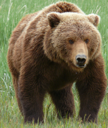

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [ ]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls = results)

In [ ]:
fns = get_image_files(path)
fns

(#567) [Path('bears/black/b1d75658-582f-4b80-ab33-20b452267331.jpg'),Path('bears/black/2adf4ce4-5824-45d1-bf2e-df9d733bafac.jpg'),Path('bears/black/579ddfdf-9fdb-4f03-ab0e-1178625abd7c.jpg'),Path('bears/black/e154cdb8-61fe-4fca-83ef-bd3db90ae04e.jpg'),Path('bears/black/804f040c-09a0-4572-a76f-d23a835be969.jpg'),Path('bears/black/251c057f-d851-4f95-93a7-21b1a23ede08.jpg'),Path('bears/black/b99bc1c7-f1ad-41dd-adda-cd813b573a3f.jpg'),Path('bears/black/b6ead96e-0956-488b-9b8a-84e66ea26cb1.jpg'),Path('bears/black/22137eb5-8e21-4948-b1b0-fd9231a9fb7e.jpg'),Path('bears/black/816a968c-76be-44c8-ad3f-65aaad877293.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#25) [Path('bears/black/60d73dee-62f7-4e57-9349-b603c51269a5.jpg'),Path('bears/black/c0596a10-a5c0-45fa-af04-709180863005.jpg'),Path('bears/black/b52e5773-e04b-450a-ad95-fd4e9e36f106.jpg'),Path('bears/black/6d771998-2d62-42bd-888e-946782051a8b.jpg'),Path('bears/black/d9c6b0d1-079f-49a3-8693-74f2ee149a2c.jpg'),Path('bears/black/bf8a6f43-c366-4221-b87b-45e56ddcda4b.jpg'),Path('bears/grizzly/1b15832e-4e38-4b14-80a8-69856cc97a8e.png'),Path('bears/grizzly/97c92691-2226-436a-9d32-3407d708947b.jpg'),Path('bears/grizzly/0a78b780-9069-467c-bf29-4cb05dc6cbd8.jpg'),Path('bears/grizzly/7bcabe39-b270-4d40-a7bc-d76e2df99ce0.jpg')...]

In [ ]:
failed.map(Path.unlink)

(#25) [None,None,None,None,None,None,None,None,None,None...]

#### Loading Image for the model

In [ ]:
bears  = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed =42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

In [ ]:
dls = bears.dataloaders(path)

#### Checking Data Augementation

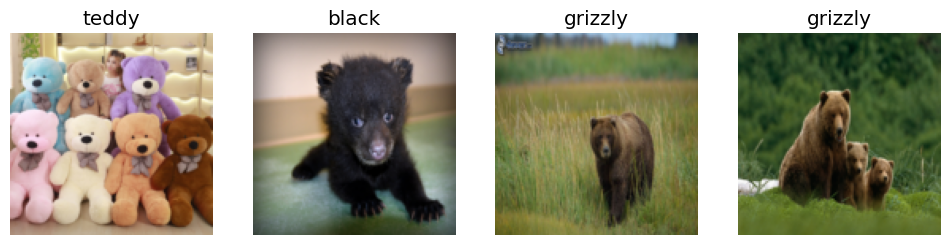

In [ ]:
dls.valid.show_batch(max_n = 4, nrows =1)

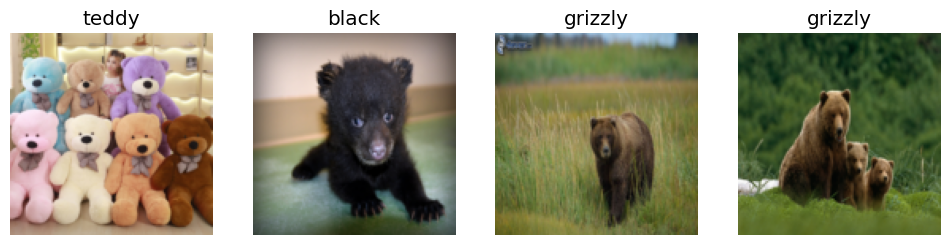

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

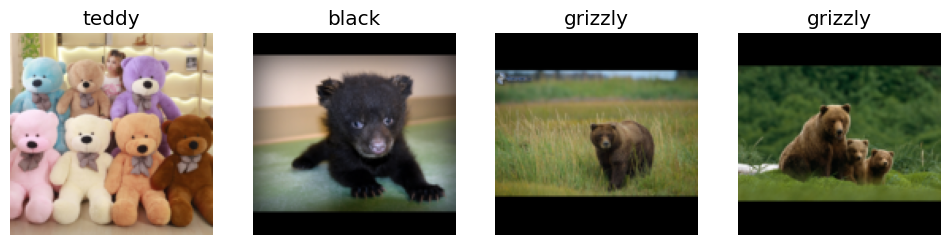

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows =1)

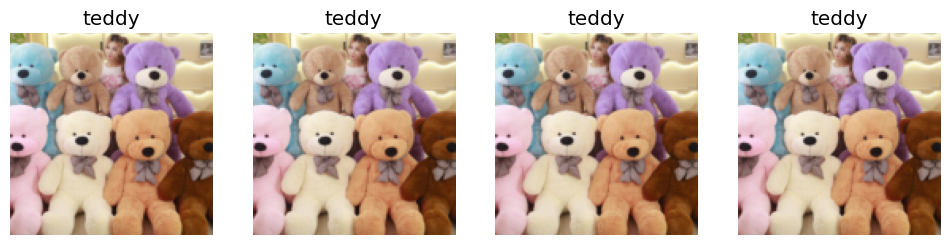

In [ ]:
bears = bears.new(item_tfms= RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

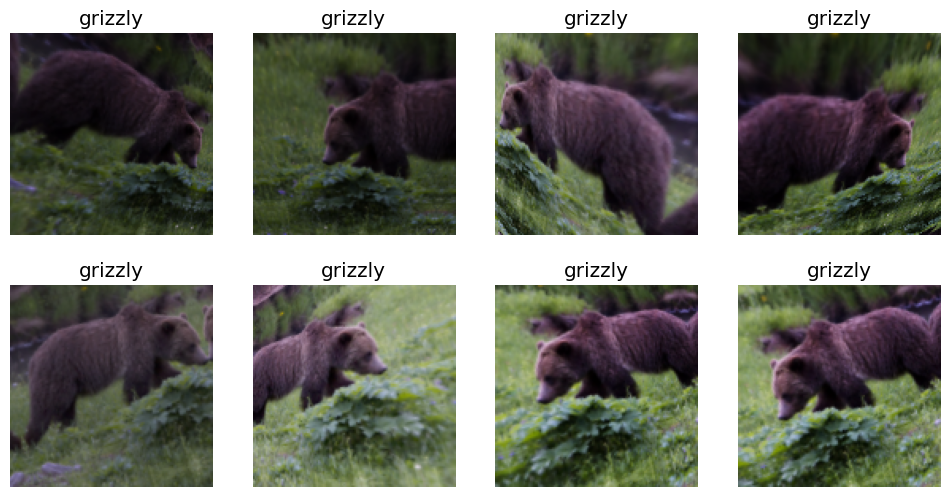

In [ ]:
bears = bears.new(item_tfms = Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique = True)

#### Fitting Data Augementation to traingin data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224,min_scale =0.5),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

#### Training the model

In [ ]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)